In [10]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn import set_config
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pickle
from imblearn.over_sampling import SMOTE

Comenzamos importando el dataset sobre el que vamos a trabajar

In [11]:
# 1. Cargar el dataset
dataset_url = "./heart_failure_clinical_records_dataset.csv"
data = pd.read_csv(dataset_url)

Realizamos una copia sobre la que realizaremos las transformaciones necesarias y sobre la que trabajaremos para crear los modelos. De esta forma, los datos originales se mantienen intactos, en caso de necesitarlos en algún momento.

In [12]:
df = data.drop(['time'], axis=1)

Fijamos una semilla con la que trabajaremos en todo momento para que el notebook sea reproducible.

In [13]:
seed = 101

# Análisis Exploratorio

Procedemos primero a realizar un análisis descriptivo de los datos, para hacernos una idea de las características generales de los datos. 

In [14]:
def descriptive_analysis(data):
    print("Información del dataset:\n")
    print(data.info())

    # Configuración de estilo
    plt.style.use("ggplot")

    # 1. Histogramas de las variables numéricas
    print("\nGeneración de histogramas\n")
    data.hist(figsize=(12, 10), bins=20, edgecolor='black')
    plt.suptitle("Distribución de las Variables", fontsize=14, fontweight='bold')
    plt.show()

    # 2. Boxplots para identificar outliers
    print("\nGeneración de boxplots\n")
    numerical_features = [
        "age", "creatinine_phosphokinase", "ejection_fraction",
        "platelets", "serum_creatinine", "serum_sodium"
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Ajustado a 2 filas y 3 columnas
    fig.suptitle("Boxplots de Variables Numéricas", fontsize=14, fontweight='bold')

    for i, feature in enumerate(numerical_features):
        row, col = divmod(i, 3)  # Calculamos la posición de la celda
        sns.boxplot(x=data[feature], ax=axes[row, col])
        axes[row, col].set_xlabel(feature, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 3. Matriz de correlación
    print("\nGeneración de matriz de correlación\n")
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
    plt.title("Matriz de Correlación", fontweight='bold')
    plt.show()


Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB
None

Generación de histogramas



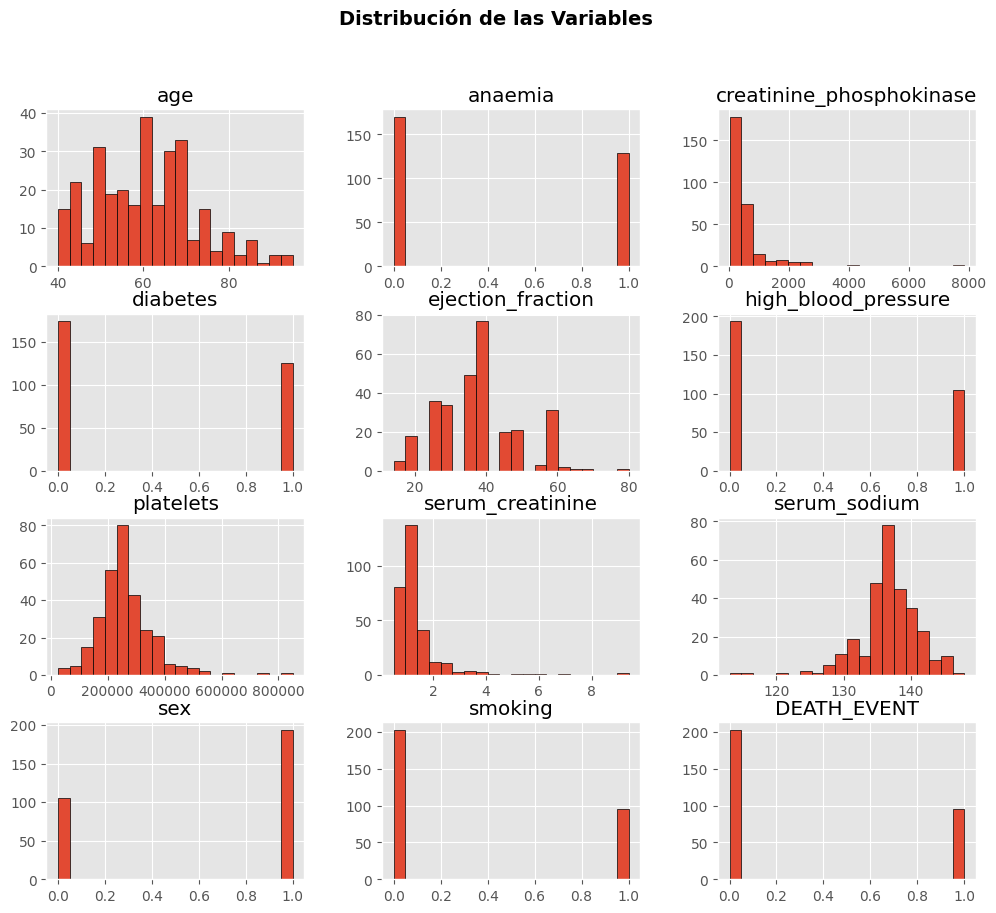


Generación de boxplots



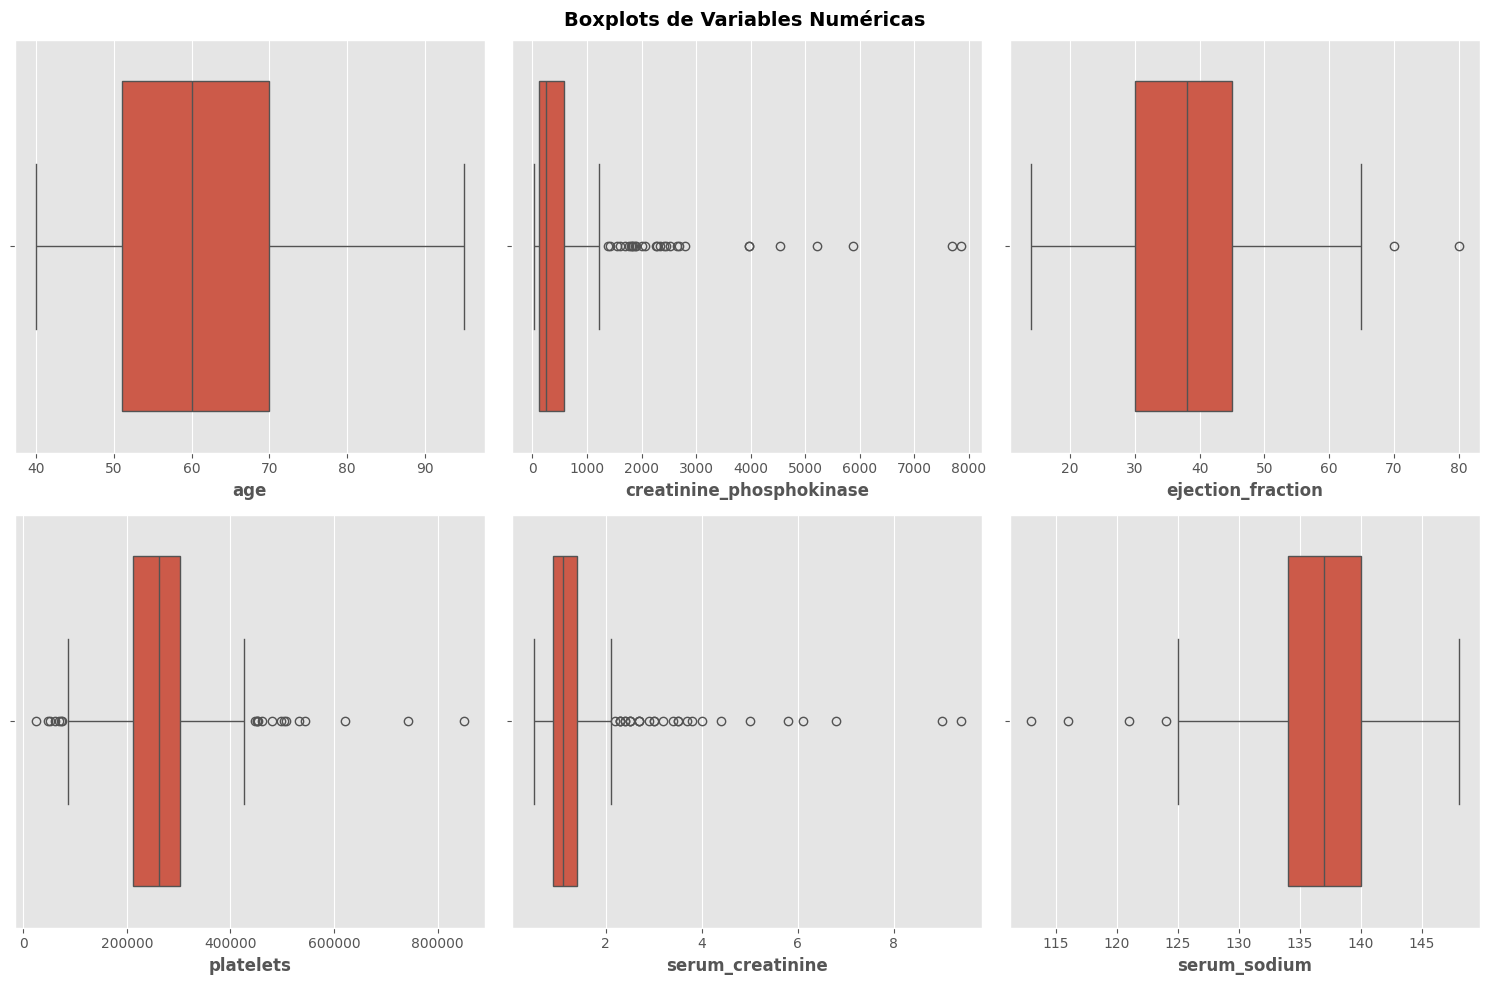


Generación de matriz de correlación



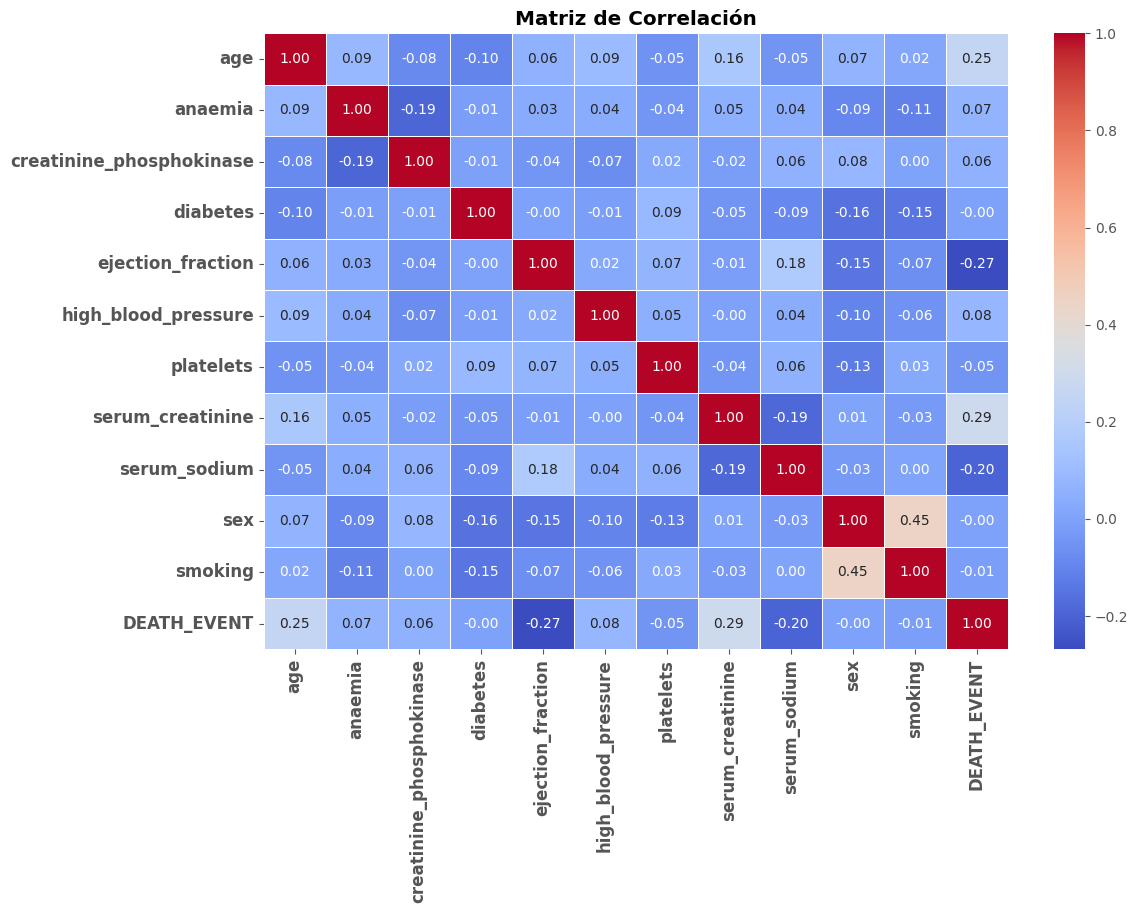

In [15]:
descriptive_analysis(df)

Modificamos la variable onjuetivo parta que sea categórica.

In [16]:
df["death_event"] = df["DEATH_EVENT"].apply(lambda x: 'yes' if x == 1 else 'no')
df = df.drop('DEATH_EVENT', axis=1)

Mostramos una vista previa de los datos

In [17]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,yes
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,yes
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,yes
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,yes
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,yes


Organizamos las variables según su tipo en numéricas, categóricas y variable objetivo.

In [18]:
# Determinamos primero la variable objetivo
target = "death_event"
# Hacemos una lista con las variables input numericas
num_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
# Hacemos una lista con las variables input categoricas
cat_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

Realizamos un análisis exploratorio de los datos, describiendo las variables, comprobando que las variables categóricas no tengan valores mal representados y buscando la presencia de posibles valores nulos.

In [106]:
print("\nValores nulos por columna:\n")
print(df.isnull().sum())


Valores nulos por columna:

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
death_event                 0
dtype: int64


In [111]:
print("\nResumen estadístico:\n", df.describe())



Resumen estadístico:
               age     anaemia  creatinine_phosphokinase    diabetes  \
count  276.000000  276.000000                276.000000  276.000000   
mean    60.856283    0.434783                457.992754    0.416667   
std     11.749742    0.496629                540.051506    0.493902   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                114.500000    0.000000   
50%     60.000000    0.000000                239.500000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               2794.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         276.000000           276.000000     276.000000   
mean           37.894928             0.355072  258788.473297   
std            11.356048             0.479405   85670.907372   
min            14.000000             0.000000   25100.000000   
25%            30

In [112]:
for col in cat_cols:
    print(f"\nValores únicos en {col}:")
    print(df[col].unique())


Valores únicos en anaemia:
[0 1]

Valores únicos en diabetes:
[0 1]

Valores únicos en high_blood_pressure:
[1 0]

Valores únicos en sex:
[1 0]

Valores únicos en smoking:
[0 1]


Observamos que no hay valores nulos ni mal representados.

A continuación eliminamos los valores outliers que hemos identificado en los boxplots.

In [21]:
df = df[(df['creatinine_phosphokinase'] < 3000) &
      (df['ejection_fraction'] < 70) &
      (df['platelets'] < 600000) &
      (df['serum_creatinine'] < 4) &
      (df['serum_sodium'] > 125)]

Definimos los vectores de datos con los que vamos a trabajar.

In [22]:
X = df.drop(target, axis=1)
y = df[target]

A continuación comprobamos el balance de clases en la variable objetivo.

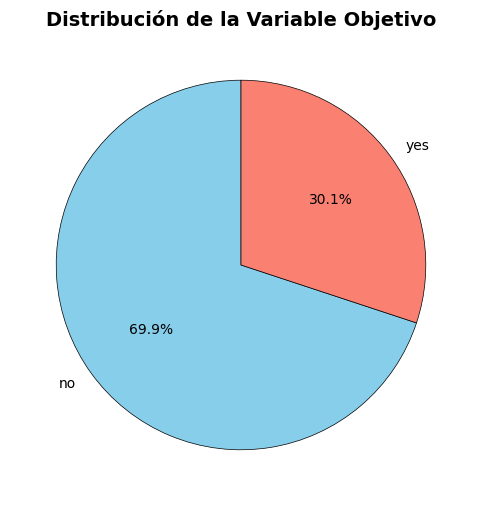

In [114]:
# Contar la cantidad de casos por clase
class_counts = y.value_counts()

# Crear gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=["skyblue", "salmon"], startangle=90, wedgeprops={'edgecolor': 'black'})

# Agregar título
plt.title("Distribución de la Variable Objetivo", fontsize=14, fontweight="bold")

plt.show()

In [23]:
# Obtener el menor y mayor valor de clases
minority_class = y.value_counts().min()
majority_class = y.value_counts().max()

# Ratio de desbalance
imbalance_ratio = majority_class / minority_class
print(f"🔍 Ratio de Desbalance: {imbalance_ratio:.2f}")

🔍 Ratio de Desbalance: 2.33


Observamos un fuerte desbalance en la variable objetivo, por lo que usaremos la técnica de SMOTE para eliminar el desbalance de clases 

In [24]:
# Crear el generador de muestras sintéticas
smote = SMOTE(random_state=seed)

# Aplicar SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Ver la nueva distribución
print(pd.Series(y_resampled).value_counts())

death_event
yes    193
no     193
Name: count, dtype: int64


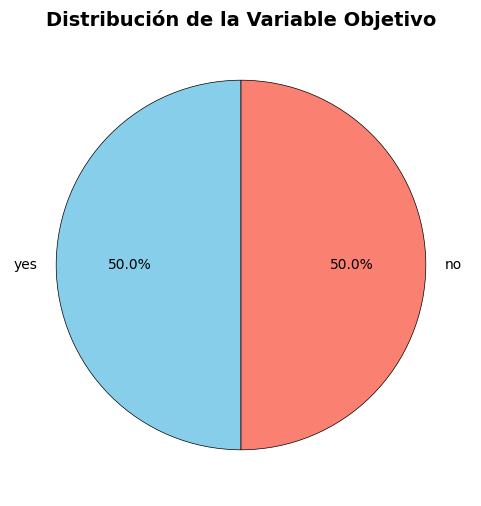

In [116]:
# Contar la cantidad de casos por clase
class_counts = y_resampled.value_counts()

# Crear gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=["skyblue", "salmon"], startangle=90, wedgeprops={'edgecolor': 'black'})

# Agregar título
plt.title("Distribución de la Variable Objetivo", fontsize=14, fontweight="bold")

plt.show()

In [25]:
# Obtener el menor y mayor valor de clases
minority_class = y_resampled.value_counts().min()
majority_class = y_resampled.value_counts().max()

# Ratio de desbalance
imbalance_ratio = majority_class / minority_class
print(f"🔍 Ratio de Desbalance: {imbalance_ratio:.2f}")

🔍 Ratio de Desbalance: 1.00


División en Train y Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)

Normalización 

In [27]:
scaler = MinMaxScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Una vez tenemos las transformaciones hechas, procedemos a realizar la modelización.

# Modelización 

**Árbol de decisión**

Usamos GridSearch con varias combinaciones de hiperparámetros para ver donde se alcanza el mejor modelo en función del accuracy.

In [28]:
## Tuneo y evaluacion predictiva del modelo para variable dependiente categorica. 

arbol_accuracy = DecisionTreeClassifier(random_state=seed)

params = {
    'min_samples_split': [5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50],
    'criterion': ["gini", "entropy"], 
    'ccp_alpha': [0, 0.0001, 0.001, 0.01]
}

# Definimos las medidas de bondad de ajuste que vamos a emplear
scoring_metrics = ['accuracy']

# cv = crossvalidation
grid_search = GridSearchCV(estimator=arbol_accuracy, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=101),
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 5, 10, 20, 50],
                         'min_samples_split': [5, 10, 20, 50, 100]},
             refit='accuracy', scoring=['accuracy'])

In [29]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search.cv_results_)

# Mostrar resultados
print("Resultados de Grid Search:")
# print(results[['params', 'mean_test_accuracy']])
print(results.sort_values(by='mean_test_accuracy', ascending=False)[['params','mean_test_accuracy']])

# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)

Resultados de Grid Search:
                                                params  mean_test_accuracy
198  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.785714
18   {'ccp_alpha': 0, 'criterion': 'gini', 'min_sam...            0.785714
188  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.785714
78   {'ccp_alpha': 0.0001, 'criterion': 'gini', 'mi...            0.785714
183  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.785714
..                                                 ...                 ...
177  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.711039
209  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.711039
115  {'ccp_alpha': 0.0001, 'criterion': 'entropy', ...            0.711039
116  {'ccp_alpha': 0.0001, 'criterion': 'entropy', ...            0.711039
239  {'ccp_alpha': 0.01, 'criterion': 'entropy', 'm...            0.711039

[240 rows x 2 columns]
DecisionTreeClassifier(ccp_alpha=0, min_samples_l

In [30]:
results.sort_values(by='mean_test_accuracy', ascending=False)[['param_ccp_alpha', 'param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_accuracy']]

,param_ccp_alpha,param_criterion,param_min_samples_leaf,param_min_samples_split,mean_test_accuracy
198,0.01,gini,10,50,0.785714
18,0,gini,10,50,0.785714
188,0.01,gini,2,50,0.785714
78,0.0001,gini,10,50,0.785714
183,0.01,gini,1,50,0.785714
...,...,...,...,...,...
177,0.001,entropy,50,20,0.711039
209,0.01,gini,50,100,0.711039
115,0.0001,entropy,50,5,0.711039
116,0.0001,entropy,50,10,0.711039


Cambiamos los parámetros para ajustarlos a un intervalo más cercano al óptimo

In [31]:
## Tuneo y evaluacion predictiva del modelo para variable dependiente categorica.
params = {
    'min_samples_split': [25, 50, 75],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50],
    'criterion': ["gini", "entropy"], 
    'ccp_alpha': [0, 0.0001, 0.001, 0.01]
}

# Definimos las medidas de bondad de ajuste que vamos a emplear
scoring_metrics = ['accuracy']

# cv = crossvalidation
grid_search = GridSearchCV(estimator=arbol_accuracy, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Obtener resultados del grid search
results = pd.DataFrame(grid_search.cv_results_)

# Mostrar resultados
print("Resultados de Grid Search:")
print(results.sort_values(by='mean_test_accuracy', ascending=False)[['params','mean_test_accuracy']])

# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)

Resultados de Grid Search:
                                                params  mean_test_accuracy
82   {'ccp_alpha': 0.001, 'criterion': 'gini', 'min...            0.785714
112  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.785714
46   {'ccp_alpha': 0.0001, 'criterion': 'gini', 'mi...            0.785714
115  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.785714
118  {'ccp_alpha': 0.01, 'criterion': 'gini', 'min_...            0.785714
..                                                 ...                 ...
106  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.711039
107  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.711039
17   {'ccp_alpha': 0, 'criterion': 'gini', 'min_sam...            0.711039
16   {'ccp_alpha': 0, 'criterion': 'gini', 'min_sam...            0.711039
143  {'ccp_alpha': 0.01, 'criterion': 'entropy', 'm...            0.711039

[144 rows x 2 columns]
DecisionTreeClassifier(ccp_alpha=0, min_samples_l

In [32]:
results.sort_values(by='mean_test_accuracy', ascending=False)[['param_ccp_alpha', 'param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_accuracy']]

,param_ccp_alpha,param_criterion,param_min_samples_leaf,param_min_samples_split,mean_test_accuracy
82,0.001,gini,10,50,0.785714
112,0.01,gini,2,50,0.785714
46,0.0001,gini,10,50,0.785714
115,0.01,gini,5,50,0.785714
118,0.01,gini,10,50,0.785714
...,...,...,...,...,...
106,0.001,entropy,50,50,0.711039
107,0.001,entropy,50,75,0.711039
17,0,gini,50,75,0.711039
16,0,gini,50,50,0.711039


Vemos que hemos encontrado el entorno de hiperparámetros óptimo, por lo que vamos a escoger los modelos con mayor accuracy y a analizar su robustez representando en boxplots las 4 etapas de validación cruzada. 

¿Qué buscamos en la visualización?

Menor dispersión en los boxplots

 - Si un modelo tiene valores muy dispersos entre folds, su rendimiento no es estable.
 - Si todos los valores están cercanos entre sí, el modelo es más robusto.

Medianas alineadas

 - Si un modelo tiene mediana consistente en todos los folds, es más confiable.
 - Si la mediana cambia mucho, el modelo es más sensible a la partición de datos.

Identificación de outliers

 - Si hay outliers en algún modelo, significa que su rendimiento varía mucho en diferentes particiones.

In [33]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[82]
res_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[112]
res_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[46]
res_4 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[115]
res_5 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[118]

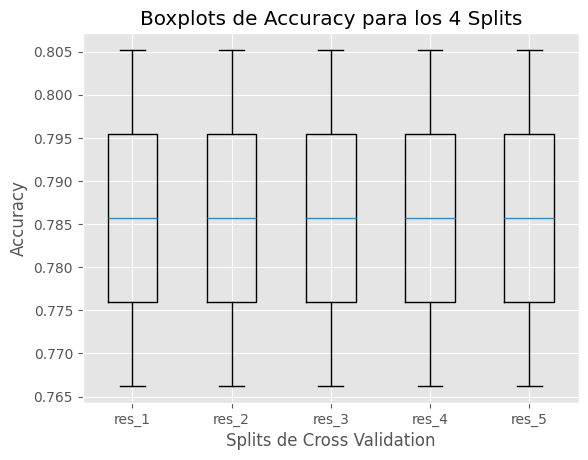

In [34]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values, res_4.values, res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

Observamos que los modelos con mayor accuracy tienen todos la misma robustez por lo que nos quedaremos con el primero de ellos.

In [35]:
# Escoger un modelo específico del GridSearchCV manualmente

# Queremos elegir el modelo en la fila 82 del results (GridSearchCV)
index_modelo = 82

# Extraer los hiperparámetros específicos de ese modelo
params_modelo = results.loc[index_modelo, ["param_ccp_alpha", "param_criterion", "param_min_samples_leaf", "param_min_samples_split"]]

# Convertir a diccionario (removiendo 'param_' del nombre de las claves)
params_modelo_dict = params_modelo.to_dict()
params_modelo_dict = {key.replace("param_", ""): value for key, value in params_modelo_dict.items()}

# Crear el modelo con estos hiperparámetros
modelo_seleccionado = DecisionTreeClassifier(**params_modelo_dict, random_state=seed)

# Entrenar el modelo con todo el conjunto de entrenamiento
modelo_seleccionado.fit(X_train_scaled, y_train)

# Hacer predicciones en el conjunto de prueba
y_train_pred = modelo_seleccionado.predict(X_train_scaled)
y_test_pred = modelo_seleccionado.predict(X_test_scaled)

Definimos funciones que emplearemos para representar la matriz de confusión y el reporte de clasificación.

In [36]:
def plot_confusion_matrix(y, y_pred, clase):
    """
    Función para graficar la matriz de confusión como un heatmap.
    
    Parámetros:
    - y: Valores reales de la variable objetivo.
    - y_pred: Predicciones del modelo.
    - clase: Train o Test
    """
    conf_matrix = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusión en {clase}")
    plt.show()

def plot_classification_report(y, y_pred, clase):
    """
    Función para graficar el reporte de clasificación como un gráfico de barras.
    
    Parámetros:
    - y: Valores reales de la variable objetivo.
    - y_pred: Predicciones del modelo.
    - clase: Train o Test
    """
    report_dict = classification_report(y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose().drop(["accuracy"], errors="ignore")

    df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8,5), colormap="coolwarm")
    plt.title(f"Reporte de Clasificación en {clase}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Puntuación")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.show()

In [37]:
def plot_confusion_and_report(y, y_pred, clase):
    """
    Función para graficar la matriz de confusión y el reporte de clasificación juntos en una sola figura
    
    Parámetros:
    - y: Valores reales de la variable objetivo.
    - y_pred: Predicciones del modelo.
    - clase: Train o Test
    """
    conf_matrix_test = confusion_matrix(y, y_pred)
    report_test = classification_report(y, y_pred, output_dict=True)
    df_report_test = pd.DataFrame(report_test).transpose().drop(["accuracy"], errors="ignore")

    # Crear la figura y los subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Matriz de Confusión
    sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=axes[0])
    axes[0].set_title(f"Matriz de Confusión - {clase}", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Predicción", fontsize=12)
    axes[0].set_ylabel("Valor Real", fontsize=12)

    # Reporte de Clasificación
    df_report_test[['precision', 'recall', 'f1-score']].plot(kind='bar', colormap="coolwarm", ax=axes[1])
    axes[1].set_title(f"Reporte de Clasificación - {clase}", fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(df_report_test.index, rotation=45, ha='right', fontsize=10)
    axes[1].set_ylabel("Puntuación", fontsize=12)
    axes[1].set_ylim(0, 1)
    axes[1].legend(loc="lower right")

    plt.subplots_adjust(wspace=0.5) 
    plt.show()

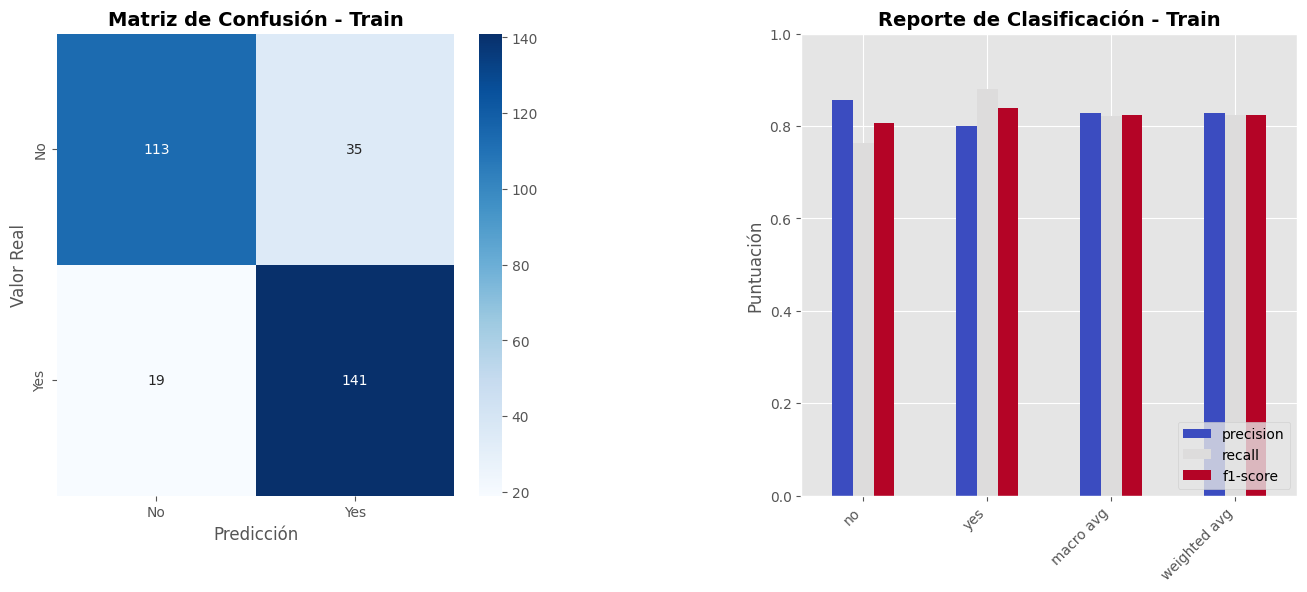

In [38]:
plot_confusion_and_report(y_train, y_train_pred, 'Train')

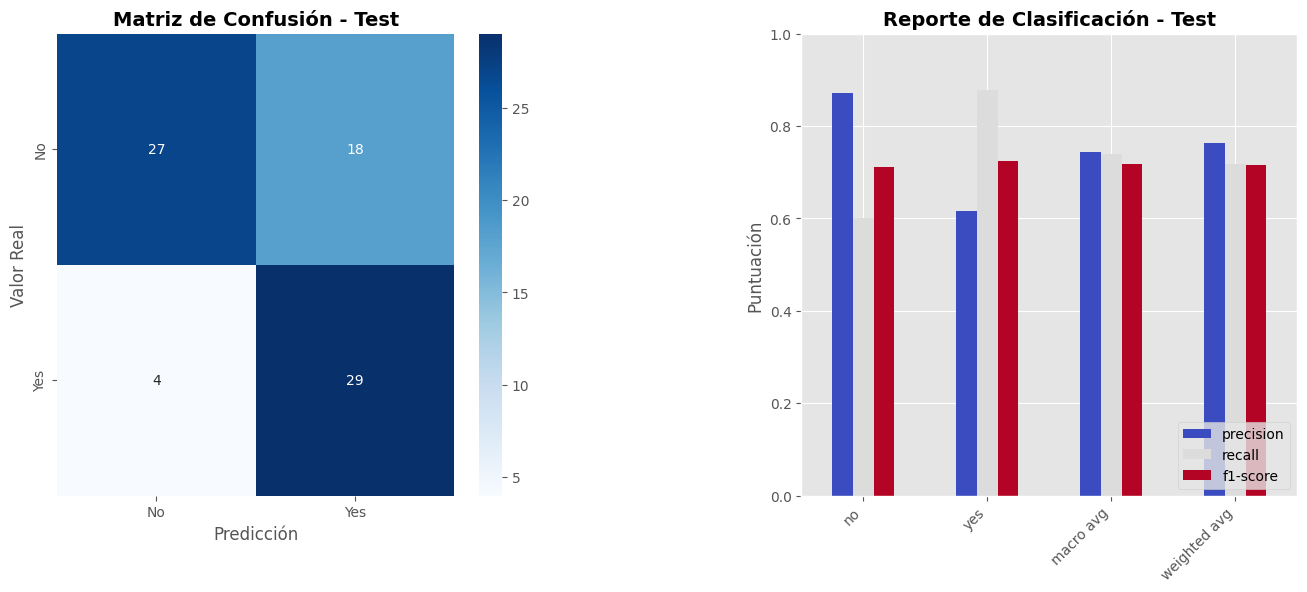

In [39]:
plot_confusion_and_report(y_test, y_test_pred, 'Test')

Guardamos estas métricas para su posterior productivización.

In [40]:
# Diccionario con métricas ya calculadas
metricas_guardadas = {
    "Train": {
        "confusion_matrix": confusion_matrix(y_train, y_train_pred).tolist(),
        "classification_report": classification_report(y_train, y_train_pred, output_dict=True)
    },
    "Test": {
        "confusion_matrix": confusion_matrix(y_test, y_test_pred).tolist(),
        "classification_report": classification_report(y_test, y_test_pred, output_dict=True)
    }
}

# Guardar en un archivo pickle
with open("Metricas/arbol_base.pkl", "wb") as file:
    pickle.dump(metricas_guardadas, file)


Observamos que la diferencia de precisión entre Train y Test no es excesivamente alta, por lo que podemos asumir que no estamos cometiendo sobreajuste muy elevado. 

De igual modo, calculamos el área bajo la curva ROC (AUC-ROC) en Train y Test para comprobar si la diferencia es muy elevada.

In [41]:
y_train_auc = pd.get_dummies(y_train,drop_first=True)

# Calcular el área bajo la curva ROC (AUC)
y_prob_train = modelo_seleccionado.predict_proba(X_train_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_auc, y_prob_train)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc:.2f}")


Área bajo la curva ROC (AUC): 0.91


In [42]:
y_test_auc = pd.get_dummies(y_test,drop_first=True)

# Calcular el área bajo la curva ROC (AUC)
y_prob_test = modelo_seleccionado.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_auc, y_prob_test)
roc_auc_test = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc_test:.2f}")


Área bajo la curva ROC (AUC): 0.79


Observamos que la diferencia es de 0.12, por lo que, pese a que no es muy elevada, podríamos estar cometiendo sobreajuste.

Representamos el árbol gráficamente

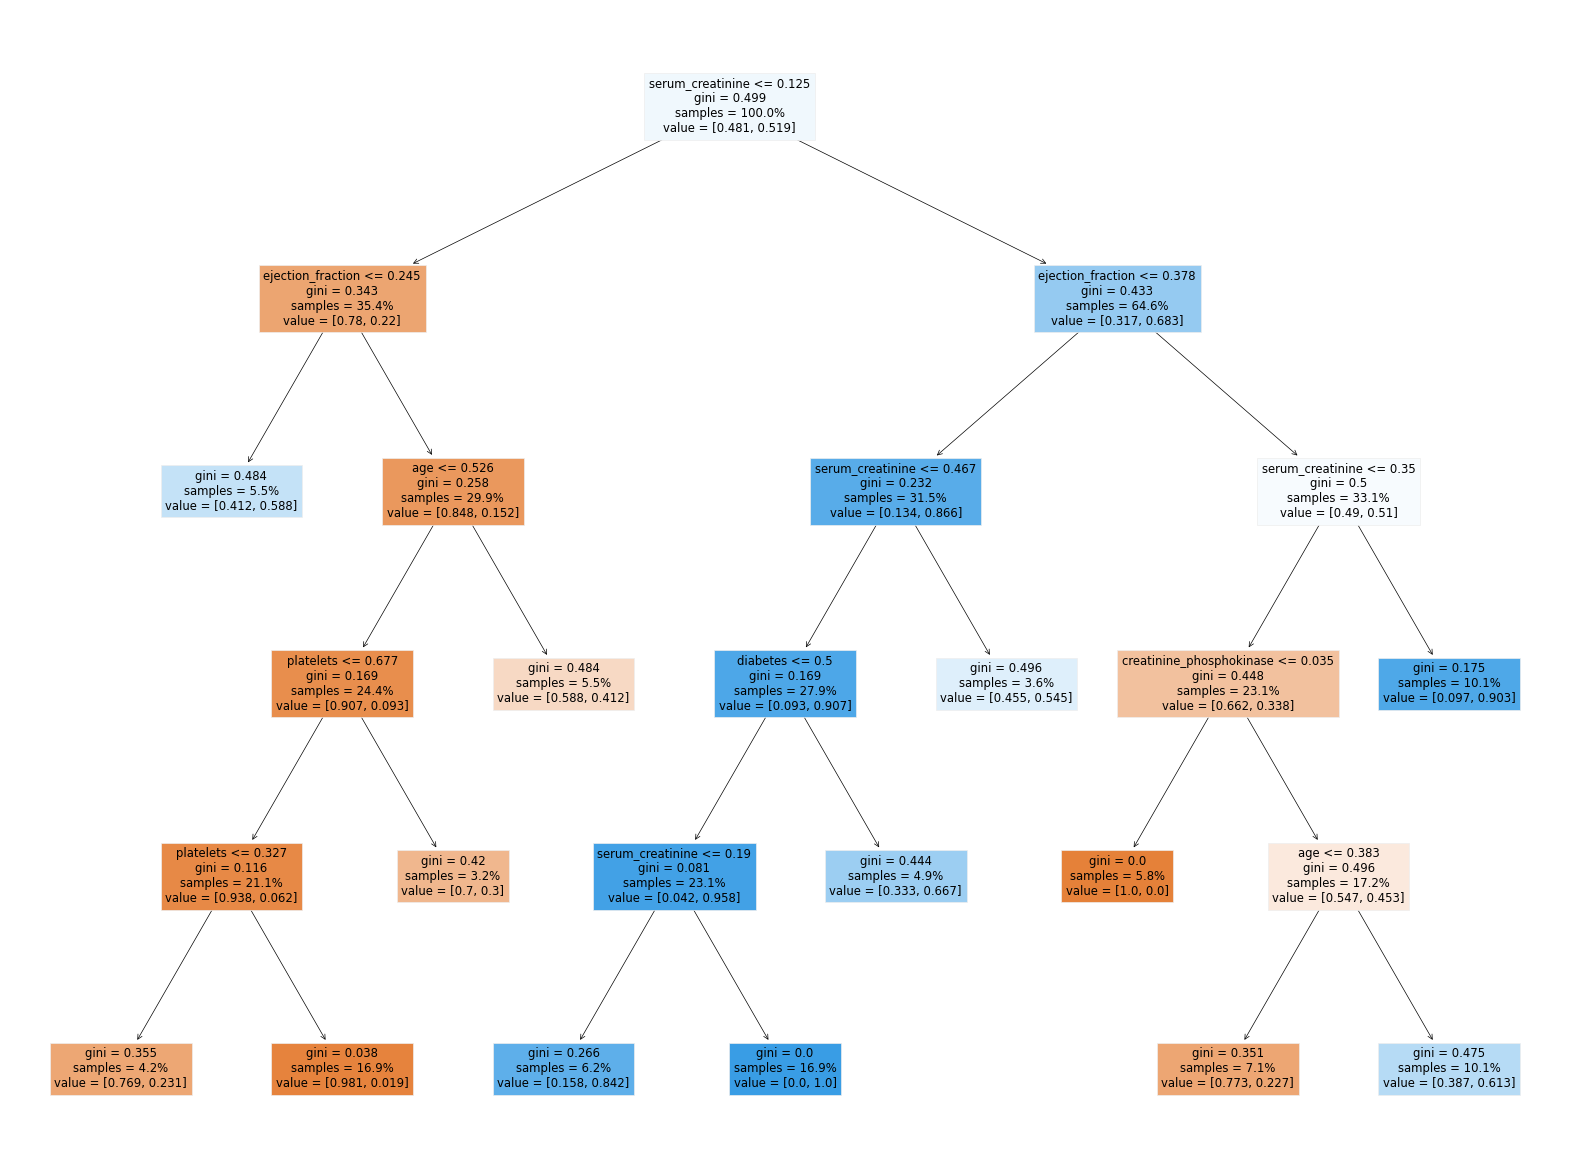

In [43]:
plt.figure(figsize=(20, 15))
plot_tree(modelo_seleccionado, feature_names=X.columns.tolist(), filled=True,
         proportion = True)
plt.show()

Observamos que el modelo identifica la creatinina como el factor más crítico para predecir la mortalidad. Si además la creatinina es alta, los diabéticos tienen un riesgo aún mayor.

Guardamos el modelo en un archivo pickle para la posterior productivización.

In [44]:
# Guardar el modelo en un archivo .pkl
file_path = "Modelos/arbol_base.pkl"
with open(file_path, "wb") as file:
    pickle.dump(modelo_seleccionado, file)

print(f"Modelo guardado en {file_path}")

Modelo guardado en Modelos/arbol_base.pkl


**Bagging**

Para empezar con el modelo de bagging, comenzaremos tomando como modelo base el que hemos escogido anteriormente. 

In [45]:
# Creamos el arbol de decision base. 
base_classifier = modelo_seleccionado
base_classifier.fit(X_train_scaled, y_train)
y_pred_base = base_classifier.predict(X_test_scaled)

# Evaluamos el rendimiento del modelo
accuracy_a = accuracy_score(y_test, y_pred_base)
print(f'Precisión del árbol estándar: {accuracy_a}')

Precisión del árbol estándar: 0.717948717948718


A continuación, tomaremos un modelo de bagging dsin optimizar para ver su precisión.

In [46]:
set_config(enable_metadata_routing=True)
bagging_model = BaggingClassifier(base_classifier, max_samples = 300, max_features = 8, n_estimators=100, random_state=seed, oob_score = True)
bagging_model.fit(X_train_scaled, y_train)
y_pred_bagging = bagging_model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
accuracy_b = accuracy_score(y_test, y_pred_bagging)
print(f'Precisión del modelo con Bagging estándar: {accuracy_b}')
print(f'Se observa una diferencia del modelo bagging con respecto al árbol de decision de: \n{accuracy_b-accuracy_a}')

Precisión del modelo con Bagging estándar: 0.7948717948717948
Se observa una diferencia del modelo bagging con respecto al árbol de decision de: 
0.07692307692307687


In [47]:
y_train_pred = bagging_model.predict(X_train_scaled)
y_test_pred = bagging_model.predict(X_test_scaled)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.8409090909090909
Se tiene un accuracy para test de: 0.7948717948717948


Observamos que la diferencia de precisión entre Train y Test no es muy elevada.  

A continuación vamos a buscar el mejor modelo de Bagging realizando un Grill sobre los hiperpárametros de Bagging.

In [48]:
# Definimos el espacio de busqueda de parametros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [1,75,150, 200],
    'max_features': [1,4,7,8],
    'bootstrap': [True], # Tomamos siempre con reemplazamiento
    'bootstrap_features': [True, False]
}
scoring_metrics = ['accuracy']


grid_search_b = GridSearchCV(bagging_model, param_grid, cv=4, scoring='accuracy', refit='accuracy')

# Realizar la búsqueda en la cuadrícula utilizando los datos
grid_search_b.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros y la mejor puntuación
best_params = grid_search_b.best_params_
best_score = grid_search_b.best_score_

print(f'Mejores parámetros: {best_params}')

Mejores parámetros: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 7, 'max_samples': 150, 'n_estimators': 50}


Volvemos a realizar el grill varias veces escogiendo parámetros más ceranos a los que se han obtenido como óptimos.

In [49]:
# Definimos el espacio de busqueda de parametros
param_grid = {
    'n_estimators': [25, 50, 75],
    'max_samples': [125, 150, 175],
    'max_features': [5, 6, 7],
    'bootstrap': [True], # Tomamos siempre con reemplazamiento
    'bootstrap_features': [True, False]
}
scoring_metrics = ['accuracy']


grid_search_b = GridSearchCV(bagging_model, param_grid, cv=4, scoring='accuracy', refit='accuracy')

# Realizar la búsqueda en la cuadrícula utilizando los datos
grid_search_b.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros y la mejor puntuación
best_params = grid_search_b.best_params_
best_score = grid_search_b.best_score_

print(f'Mejores parámetros: {best_params}')

Mejores parámetros: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 6, 'max_samples': 150, 'n_estimators': 50}


In [50]:
# Obtener el mejor modelo
best_model_bagging = grid_search_b.best_estimator_
y_pred_best_bagging = best_model_bagging.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
accuracy_b_b = accuracy_score(y_test, y_pred_best_bagging)
print(f'Precisión del modelo con Bagging CV y best_params: {accuracy_b_b}')

Precisión del modelo con Bagging CV y best_params: 0.7692307692307693


In [51]:
y_train_pred = best_model_bagging.predict(X_train_scaled)
y_test_pred = best_model_bagging.predict(X_test_scaled)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.7954545454545454
Se tiene un accuracy para test de: 0.7692307692307693


Comparamos la precisión del árbol base, el bagging sin optimizar y el bagging optimizado con GridSearchCV

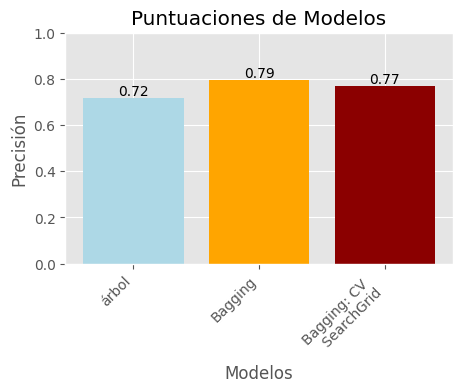

In [52]:
model_names = ['árbol', 'Bagging', 'Bagging: CV \n SearchGrid']
scores = [accuracy_a, accuracy_b, accuracy_b_b]
# Crear el diagrama de barras
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['lightblue', 'orange', 'darkred'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=45, ha='right')
plt.ylim(0, 1.0)  # Ajustar el rango del eje y según tus necesidades
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')

# Añadir los valores encima de las barras centrados
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')

plt.show()

Observamos que, pese a que el bagging no optimizado con GridSearch tiene un poco más de precisión en la predicción, el modelo de Bagging CV tiene un accuracy muy similar en Train y Test, por lo que podemos asumir que presenta menor sobreajuste.

Comprobaremos la robustez de los mejores modelos para ver si realmente debemos quedarnos con best_estimator.

In [53]:
results = pd.DataFrame(grid_search_b.cv_results_)
sorted_results = results.sort_values(by='rank_test_score', ascending=True)
sorted_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_bootstrap_features,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
13,0.100718,0.001787,0.007221,0.000838,True,True,6,150,50,"{'bootstrap': True, 'bootstrap_features': True...",0.753247,0.844156,0.792208,0.727273,0.779221,0.044041,1
22,0.102317,0.003755,0.007176,0.000493,True,True,7,150,50,"{'bootstrap': True, 'bootstrap_features': True...",0.753247,0.831169,0.779221,0.753247,0.779221,0.031812,1
12,0.054807,0.004070,0.004342,0.000365,True,True,6,150,25,"{'bootstrap': True, 'bootstrap_features': True...",0.727273,0.844156,0.805195,0.740260,0.779221,0.047717,3
3,0.049359,0.001653,0.004245,0.000421,True,True,5,150,25,"{'bootstrap': True, 'bootstrap_features': True...",0.727273,0.831169,0.805195,0.740260,0.775974,0.043439,4
4,0.099007,0.002170,0.007179,0.000472,True,True,5,150,50,"{'bootstrap': True, 'bootstrap_features': True...",0.753247,0.831169,0.792208,0.727273,0.775974,0.039365,4


Observamos que el primero de estos modelos es el best_estimator

In [54]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[0]
res_2 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[1]
res_3 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[2]
res_4 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[3]
res_5 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[4]

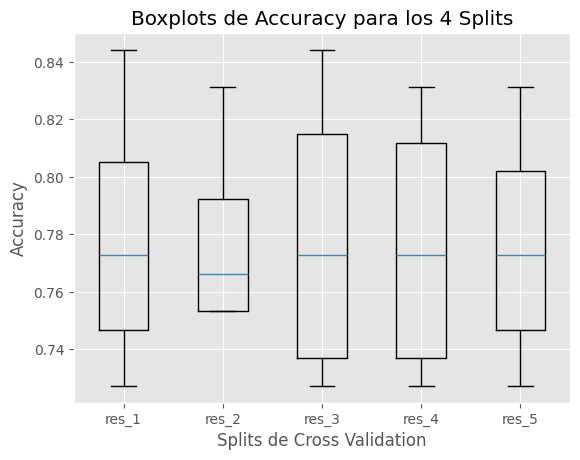

In [55]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

Observamos que el modelo 2 es el que presenta una menor variabilidad. Por ello, lo escogemos como modelo final de bagging.

In [56]:
bagging = BaggingClassifier(base_classifier,**sorted_results['params'].iloc[1],random_state=seed)
bagging.fit(X_train_scaled, y_train)
y_train_pred = modelo_seleccionado.predict(X_train_scaled)
y_test_pred = bagging.predict(X_test_scaled)

Representamos la matriz de confusión y el reporte de clasificación.

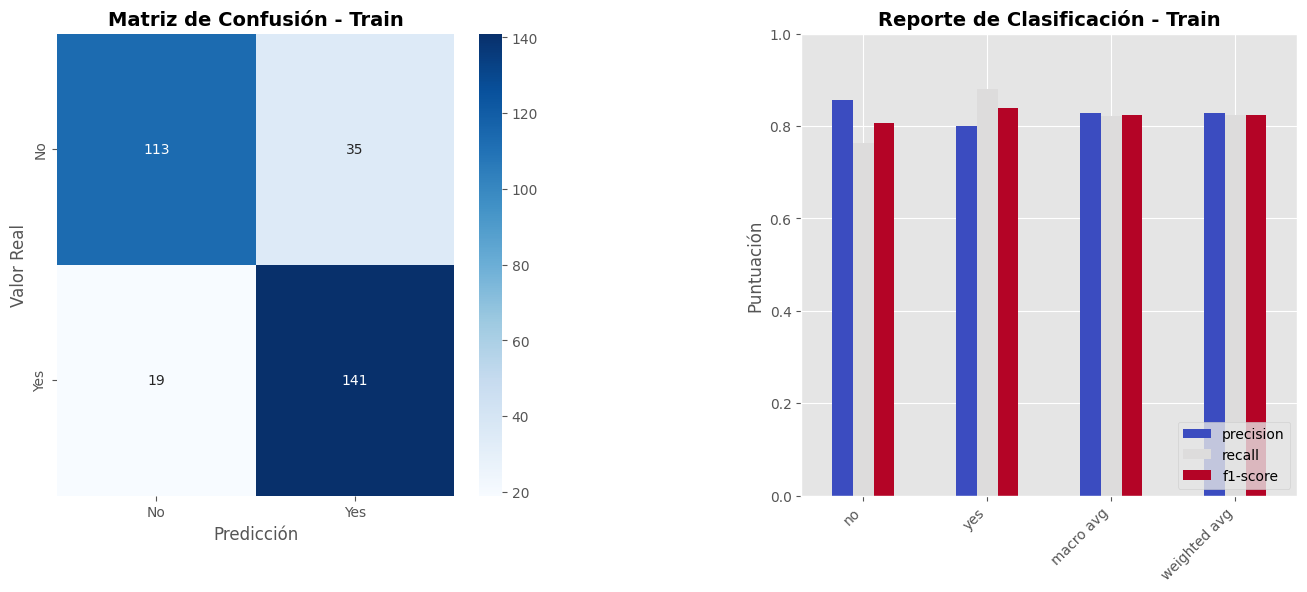

In [57]:
plot_confusion_and_report(y_train, y_train_pred, 'Train')

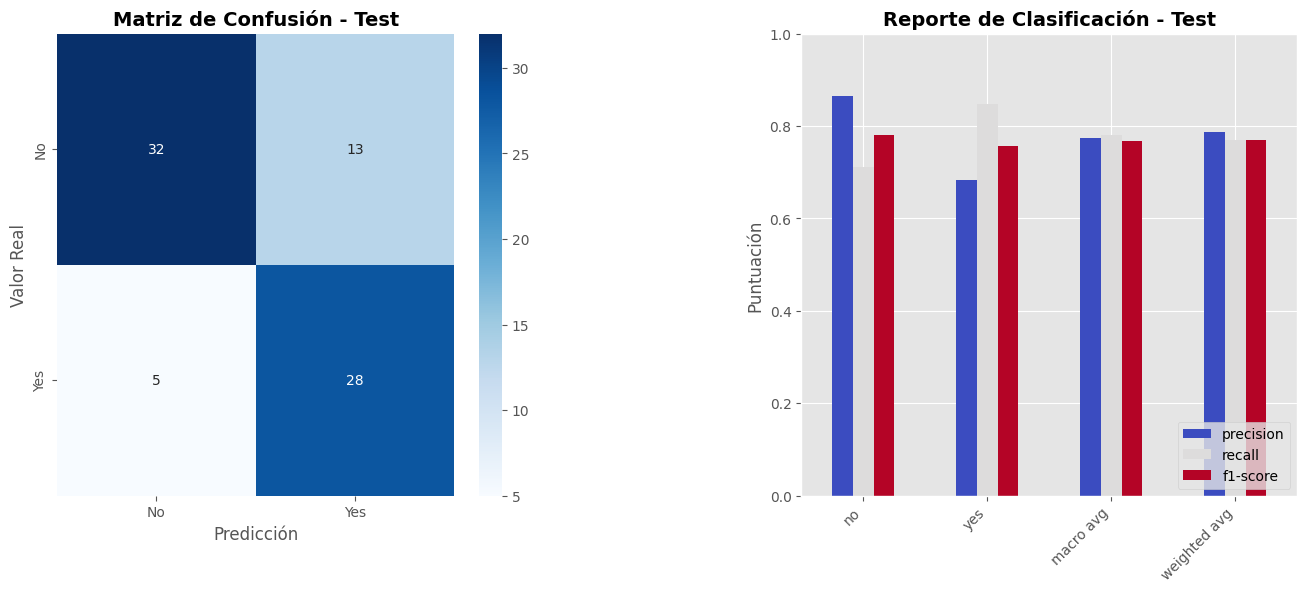

In [58]:
plot_confusion_and_report(y_test, y_test_pred, 'Test')

Observamos que los resultados en Train y test son similares, por lo que podemos asumir que no hay un sobreajuste excesivo.

Guardamos las métricas en un pickle para su posterior productivización.

In [59]:
# Diccionario con métricas ya calculadas
metricas_guardadas = {
    "Train": {
        "confusion_matrix": confusion_matrix(y_train, y_train_pred).tolist(),
        "classification_report": classification_report(y_train, y_train_pred, output_dict=True)
    },
    "Test": {
        "confusion_matrix": confusion_matrix(y_test, y_test_pred).tolist(),
        "classification_report": classification_report(y_test, y_test_pred, output_dict=True)
    }
}

# Guardar en un archivo pickle
with open("Metricas/bagging.pkl", "wb") as file:
    pickle.dump(metricas_guardadas, file)


Guardamos el modelo en un pickle para la posterior productivización

In [60]:
# Guardar el modelo en un archivo .pkl
file_path = "Modelos/bagging.pkl"
with open(file_path, "wb") as file:
    pickle.dump(bagging, file)

print(f"Modelo guardado en {file_path}")

Modelo guardado en Modelos/bagging.pkl


**Random Forest**

Comenzamos con el modelo de Random Forest realizando un grill sobre los hiperparámetros

In [61]:
RF_model = RandomForestClassifier(random_state=seed)

params = {
    'n_estimators' : [50,100],
    'max_depth': [8, 10, 12],
    'bootstrap': [True],
    'min_samples_leaf' : [2, 3, 5],
    'min_samples_split': [2, 3, 5],
    'criterion': ["gini", "entropy"]
}

scoring_metrics = ['accuracy']

grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=101),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 10, 12],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [50, 100]},
             refit='accuracy', scoring=['accuracy'])

In [62]:
# Obtener el mejor modelo
best_model_RF = grid_search_RF.best_estimator_
print(grid_search_RF.best_estimator_)


y_pred_rf = best_model_RF.predict(X_test_scaled)
accuracy_rf_gs = accuracy_score(y_test, y_pred_rf)

# Evaluar el rendimiento del modelo
print(f'Precision del Random Forest: {accuracy_rf_gs}')

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=101)
Precision del Random Forest: 0.8205128205128205


Volvemos a probar varias veces con valores cercanos al óptimo encontrado.

In [63]:
RF_model = RandomForestClassifier(random_state=seed)

params = {
    'n_estimators' : [125, 150, 200],
    'max_depth': [5, 6, 8],
    'bootstrap': [True],
    'min_samples_leaf' : [2, 3, 5],
    'min_samples_split': [2, 4, 6],
    'criterion': ["gini", "entropy"]
}

scoring_metrics = ['accuracy']

grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=101),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 8], 'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [125, 150, 200]},
             refit='accuracy', scoring=['accuracy'])

In [64]:
# Obtener el mejor modelo
best_model_RF = grid_search_RF.best_estimator_

y_pred_rf = best_model_RF.predict(X_test_scaled)
accuracy_rf_gs = accuracy_score(y_test, y_pred_rf)

best_params = grid_search_RF.best_params_
best_score = grid_search_RF.best_score_

print(best_model_RF)
print(best_params)

# Evaluar el rendimiento del modelo
print(f'Precision del Random Forest: {accuracy_rf_gs}')

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5,
                       n_estimators=150, random_state=101)
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150}
Precision del Random Forest: 0.8205128205128205


A continuación, comprobamos la posible presencia de sobreajuste comparando la predicción en Train y Test y viendo que es similar.

In [65]:
y_train_pred = best_model_RF.predict(X_train_scaled)
y_test_pred = best_model_RF.predict(X_test_scaled)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.9090909090909091
Se tiene un accuracy para test de: 0.8205128205128205


Observamos que la precisión en Train y Test no difiere demasiado.

In [66]:
results = pd.DataFrame(grid_search_RF.cv_results_)
sorted_results = results.sort_values(by='rank_test_accuracy', ascending=True).head(5)
sorted_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
160,0.190395,0.002631,0.010222,0.001296,True,entropy,8,5,6,150,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.766234,0.831169,0.818182,0.727273,0.785714,0.041579,1
157,0.192368,0.005438,0.010242,0.000422,True,entropy,8,5,4,150,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.766234,0.831169,0.818182,0.727273,0.785714,0.041579,1
154,0.199950,0.007466,0.010645,0.000751,True,entropy,8,5,2,150,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.766234,0.831169,0.818182,0.727273,0.785714,0.041579,1
159,0.159763,0.001694,0.008701,0.000420,True,entropy,8,5,6,125,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.753247,0.831169,0.818182,0.740260,0.785714,0.039498,4
156,0.160731,0.004923,0.009180,0.000862,True,entropy,8,5,4,125,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.753247,0.831169,0.818182,0.740260,0.785714,0.039498,4


In [67]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

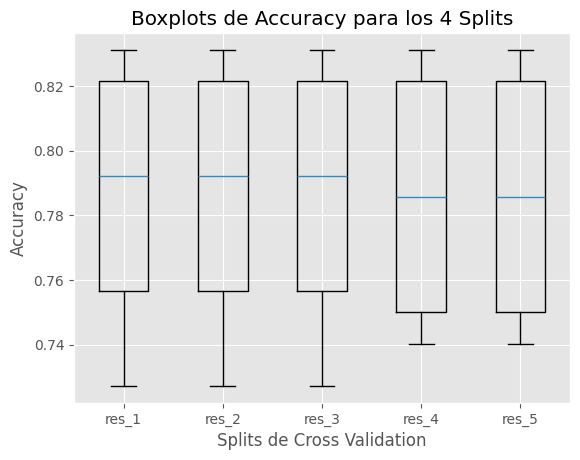

In [68]:
# Creamos un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

Observamos que los modelos 4 y 5 presentan una menor variabilidad entre etapas de validación cruzada, por lo que son más robustos. Escogeremos el modelo 4 como el definitivo.

In [69]:
random_forest = RandomForestClassifier(**sorted_results['params'].iloc[3],random_state=seed)
random_forest.fit(X_train_scaled, y_train)
y_train_pred = random_forest.predict(X_train_scaled)
y_test_pred = random_forest.predict(X_test_scaled)

Representamos la matriz de confusión y el reporte de clasificación para Train y Test.

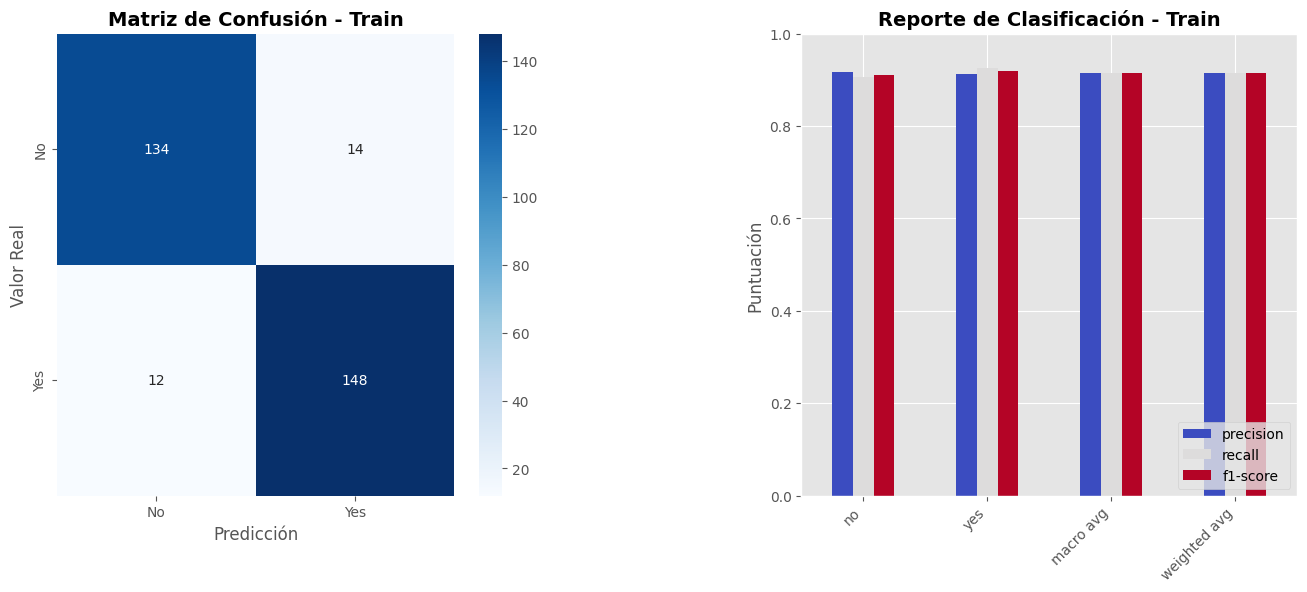

In [70]:
plot_confusion_and_report(y_train, y_train_pred, 'Train')

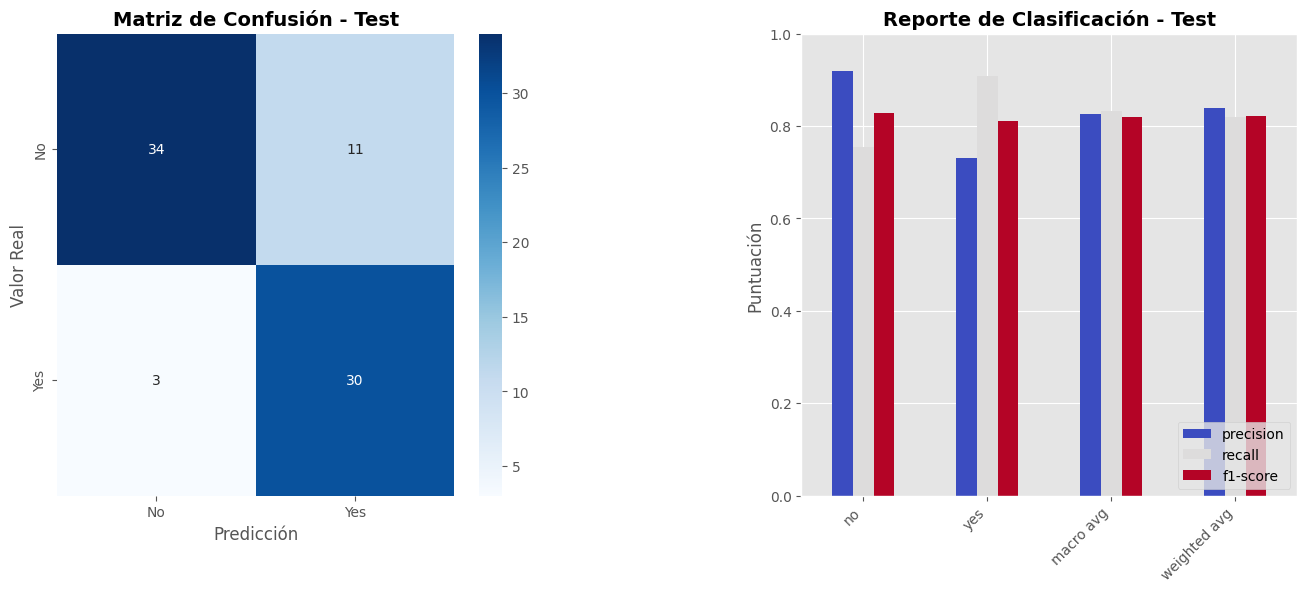

In [71]:
plot_confusion_and_report(y_test, y_test_pred, 'Test')

Observamos que los resultados en Train y test son similares, por lo que podemos asumir que no hay un sobreajuste excesivo.

Guardamos las métricas en un pickle para su posterior productivización.

In [72]:
# Diccionario con métricas ya calculadas
metricas_guardadas = {
    "Train": {
        "confusion_matrix": confusion_matrix(y_train, y_train_pred).tolist(),
        "classification_report": classification_report(y_train, y_train_pred, output_dict=True)
    },
    "Test": {
        "confusion_matrix": confusion_matrix(y_test, y_test_pred).tolist(),
        "classification_report": classification_report(y_test, y_test_pred, output_dict=True)
    }
}

# Guardar en un archivo pickle
with open("Metricas/random_forest.pkl", "wb") as file:
    pickle.dump(metricas_guardadas, file)


In [73]:
# Guardar el modelo en un archivo .pkl
file_path = "Modelos/random_forest.pkl"
with open(file_path, "wb") as file:
    pickle.dump(random_forest, file)

print(f"Modelo guardado en {file_path}")

Modelo guardado en Modelos/random_forest.pkl


**Gradient Boosting**

Comenzamos con el modelo de Gradient Boosting. Para ello, comenzaremos con un modelo sin optimizar los parámetros y calculamos su precisión en accuracy.

In [74]:
gb_classifier = GradientBoostingClassifier(n_estimators = 450, subsample = 1, random_state = seed, n_iter_no_change = 10)
gb_classifier.fit(X_train_scaled, y_train)
y_pred_base = gb_classifier.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
accuracy_a = accuracy_score(y_test, y_pred_base)
print(f'Precisión de gradient boosting: {accuracy_a}')

Precisión de gradient boosting: 0.7435897435897436


Comprobamos la posible presencia de sobreajuste

In [75]:
y_train_pred = gb_classifier.predict(X_train_scaled)
y_test_pred = gb_classifier.predict(X_test_scaled)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.9675324675324676
Se tiene un accuracy para test de: 0.7435897435897436


Vemos que la precisión en Test es bastante inferior a la precisión en Train.

De nuevo realizanos un grill sobre los hiperparámetros usando GridSearchCV.

In [76]:
params = {
    'loss': ["log_loss", "exponential"],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200, 250, 300],
    'n_iter_no_change': [None, 5],
    'max_depth': [4, 5, 6],
    'min_samples_leaf' : [1, 2, 3],
    'min_samples_split': [2, 3],
}

scoring_metrics = ['accuracy']

grid_search_GB = GridSearchCV(estimator=gb_classifier, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_GB.fit(X_train_scaled, y_train)

GridSearchCV(cv=4,
             estimator=GradientBoostingClassifier(n_estimators=450,
                                                  n_iter_no_change=10,
                                                  random_state=101,
                                                  subsample=1),
             param_grid={'learning_rate': [0.1, 0.2],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [4, 5, 6], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [200, 250, 300],
                         'n_iter_no_change': [None, 5]},
             refit='accuracy', scoring=['accuracy'])

In [77]:
modelo_GB = grid_search_GB.best_estimator_

best_params = grid_search_GB.best_params_

y_train_pred_gb = modelo_GB.predict(X_train_scaled)
y_test_pred_gb = modelo_GB.predict(X_test_scaled)

print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred_gb)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred_gb)}')

Se tiene un accuracy para train de: 1.0
Se tiene un accuracy para test de: 0.7564102564102564


Observamos un aumento muy considerable de precisión en train pero seguimos teniendo menor precisión en test, por lo que podemos concluir la presencia de sobreajuste.

In [78]:
gb_classifier = GradientBoostingClassifier(random_state = seed)

params = {
    'loss': ["log_loss", "exponential"],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [50, 100],
    'n_iter_no_change': [None, 5],
    'max_depth':  [2, 3, 4],
    'min_samples_leaf' : [1, 2, 3],
    'min_samples_split': [2, 3],
    # 'subsample': [0.9]
}

scoring_metrics = ['accuracy']

grid_search_GB = GridSearchCV(estimator=gb_classifier, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_GB.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=101),
             param_grid={'learning_rate': [0.01, 0.05],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [2, 3, 4], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3], 'n_estimators': [50, 100],
                         'n_iter_no_change': [None, 5]},
             refit='accuracy', scoring=['accuracy'])

In [79]:
results = pd.DataFrame(grid_search_GB.cv_results_)
sorted_results = results.sort_values(by='rank_test_accuracy', ascending=True).head(5)

# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

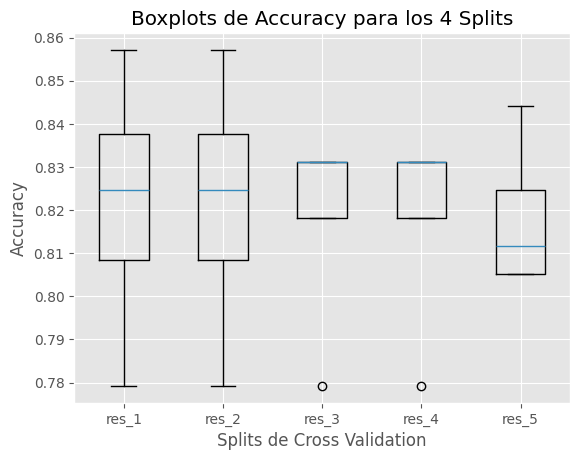

In [80]:
# Creamos un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

Vemos que el modelo 1 presenta menor variabilidad entre las etapas de validación cruzada, por lo que lo escogemos como el modelo definitivo.

In [81]:
modelo_GB =  GradientBoostingClassifier(**sorted_results['params'].iloc[4],random_state=seed)
modelo_GB.fit(X_train_scaled, y_train)
y_train_pred = modelo_GB.predict(X_train_scaled)
y_test_pred = modelo_GB.predict(X_test_scaled)

In [82]:
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.9090909090909091
Se tiene un accuracy para test de: 0.8205128205128205


Observamos que la diferencia de precisión es mucho menor.

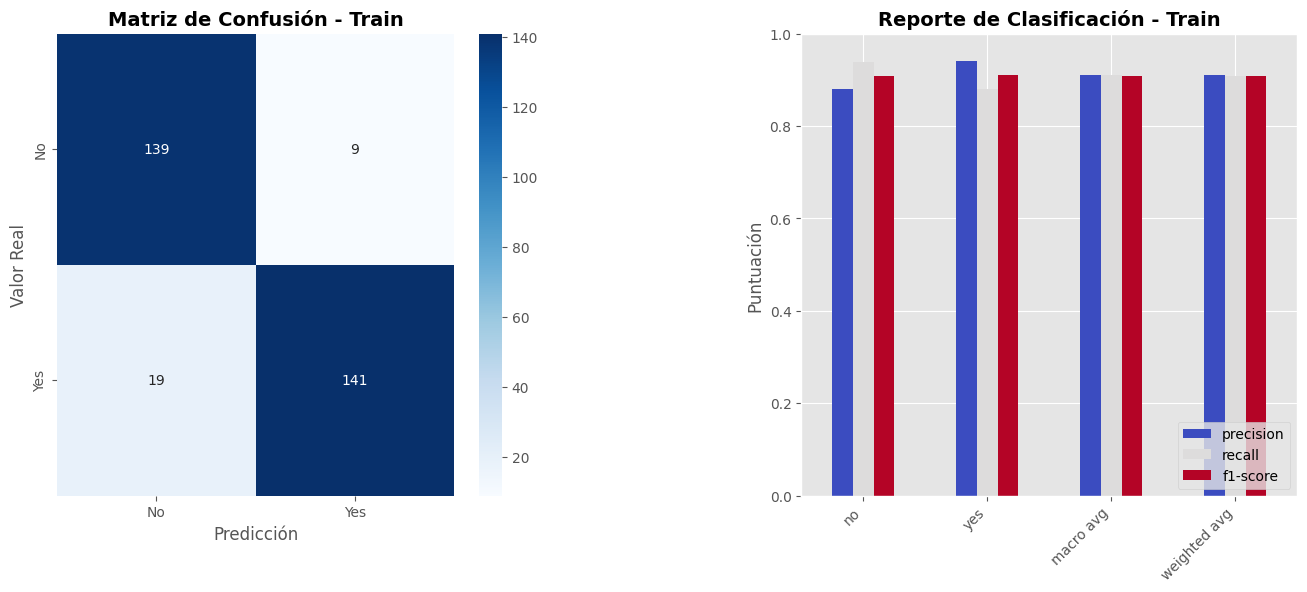

In [83]:
plot_confusion_and_report(y_train, y_train_pred, 'Train')

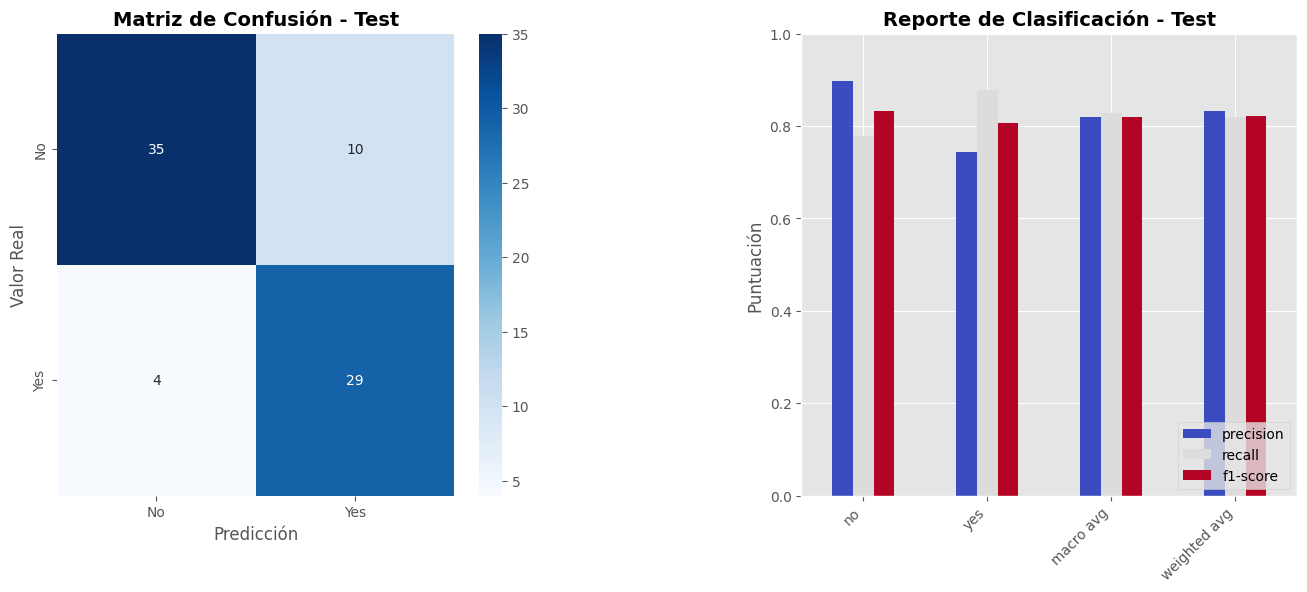

In [84]:
plot_confusion_and_report(y_test, y_test_pred, 'Test')

Observando los reportes de clasificación de train y Test, podemos deducir que no estamos cometiendo un sobreajuste muy elevado, ya que la prcisión en Train y Test es similar.

Guardamos las métricas en un pickle para su posterior productivización

In [85]:
# Diccionario con métricas ya calculadas
metricas_guardadas = {
    "Train": {
        "confusion_matrix": confusion_matrix(y_train, y_train_pred).tolist(),
        "classification_report": classification_report(y_train, y_train_pred, output_dict=True)
    },
    "Test": {
        "confusion_matrix": confusion_matrix(y_test, y_test_pred).tolist(),
        "classification_report": classification_report(y_test, y_test_pred, output_dict=True)
    }
}

# Guardar en un archivo pickle
with open("Metricas/gradient_boosting.pkl", "wb") as file:
    pickle.dump(metricas_guardadas, file)


Guardamos el modelo en un pickle para su posterior productivización.

In [86]:
# Guardar el modelo en un archivo .pkl
file_path = "Modelos/gradient_boosting.pkl"
with open(file_path, "wb") as file:
    pickle.dump(modelo_GB, file)

print(f"Modelo guardado en {file_path}")

Modelo guardado en Modelos/gradient_boosting.pkl


**XGBOOST**

Para usar XGBoost, debemos primero convertir la variable objetivo a numérica.

In [87]:
y_train_cat = y_train.apply(lambda x: 1 if x == 'yes' else 0)
y_test_cat = y_test.apply(lambda x: 1 if x == 'yes' else 0)

Comenzamos con un modelo sin optimizar.

In [88]:
xgb_classifier = XGBClassifier(objective="binary:logistic", booster = 'gbtree', n_estimators = 20, eta = 0.1, gamma = 1,
                               random_state=seed, max_depth = 15, tree_method = 'hist')
xgb_classifier.fit(X_train_scaled, y_train_cat)
y_pred_base = xgb_classifier.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
accuracy_a = accuracy_score(y_test_cat, y_pred_base)
print(f'Precisión de gradient boosting: {accuracy_a}')

Precisión de gradient boosting: 0.8205128205128205


In [89]:
y_train_pred = xgb_classifier.predict(X_train_scaled)
y_test_pred = xgb_classifier.predict(X_test_scaled)

print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_cat,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_cat,y_test_pred)}')

Se tiene un accuracy para train de: 0.9545454545454546
Se tiene un accuracy para test de: 0.8205128205128205


Observamos que aunque la precisión en Train es elevada, la precisión en Test es algo menor, por lo que realizaremos un GridSearchCV con menor número de estimadores.

In [90]:
params = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [2, 3, 4],  
    'subsample': [0.5, 0.7, 0.9],  
    'colsample_bytree': [0.5, 0.7, 0.9],  
    'reg_alpha': [0, 0.1, 0.5],  
    'reg_lambda': [0.5, 1.0, 2.0]
}

scoring_metrics = ['accuracy']

grid_search_XGB = GridSearchCV(estimator=xgb_classifier, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_XGB.fit(X_train_scaled, y_train_cat)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric=None, feature_types=None,
                                     gamma=1, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_r...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=20,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100],
                         'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0.5, 1.0, 2.0],
                         'subsample': [0.5, 0.7, 0.9]},
             refit='accuracy', scoring=['accuracy'])

In [91]:
modelo_XGB = grid_search_XGB.best_estimator_

y_train_pred_xgb = modelo_XGB.predict(X_train_scaled)
y_test_pred_xgb = modelo_XGB.predict(X_test_scaled)

print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_cat,y_train_pred_xgb)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_cat,y_test_pred_xgb)}')

Se tiene un accuracy para train de: 0.9025974025974026
Se tiene un accuracy para test de: 0.8333333333333334


Observamos cómo la diferencia de precisión entre Train y test es menor ahora.

In [92]:
results = pd.DataFrame(grid_search_XGB.cv_results_)
sorted_results = results.sort_values(by='rank_test_accuracy', ascending=True).head(5)

# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

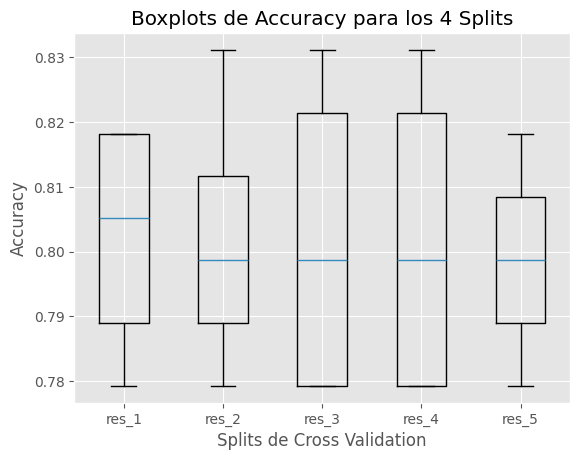

In [93]:
# Creamos un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

El modelo 5 es el que menor variabilidad presenta entre las diferentes etapas de validación cruzada, por lo que lo escogemos como el modelo definitivo de XGboost.

In [94]:
xgboost = XGBClassifier(**sorted_results['params'].iloc[4],random_state=seed)
xgboost.fit(X_train_scaled, y_train_cat)
y_train_pred = xgboost.predict(X_train_scaled)
y_test_pred = xgboost.predict(X_test_scaled)

In [95]:
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_cat,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_cat,y_test_pred)}')

Se tiene un accuracy para train de: 0.9188311688311688
Se tiene un accuracy para test de: 0.7948717948717948


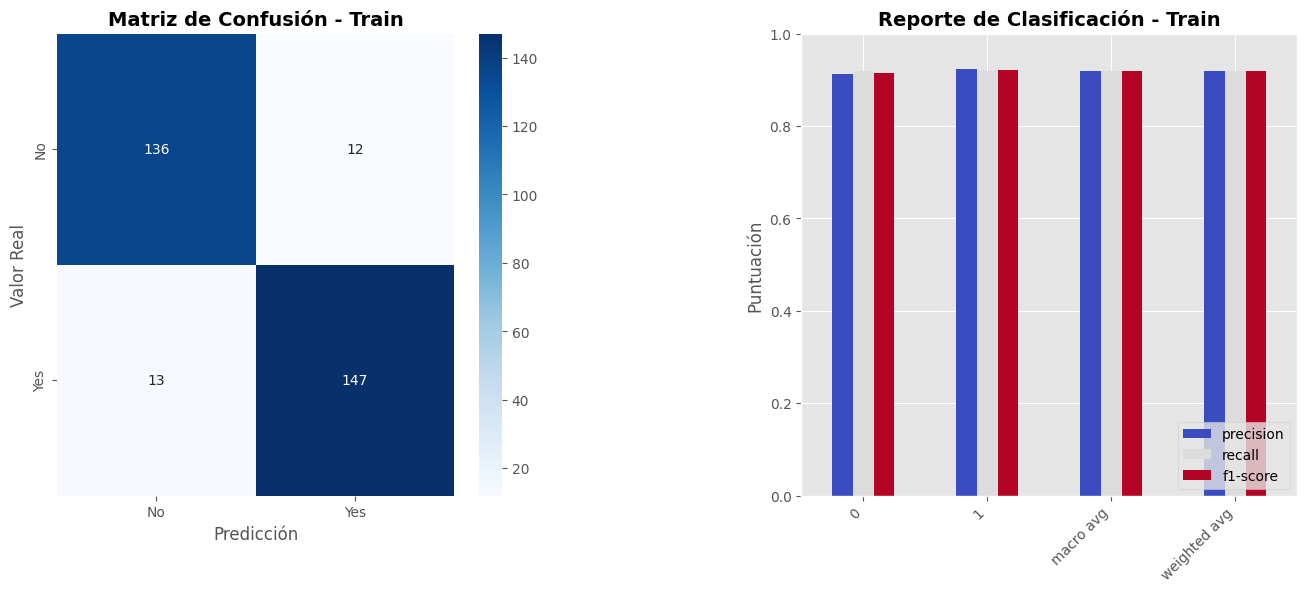

In [96]:
plot_confusion_and_report(y_train_cat, y_train_pred, 'Train')

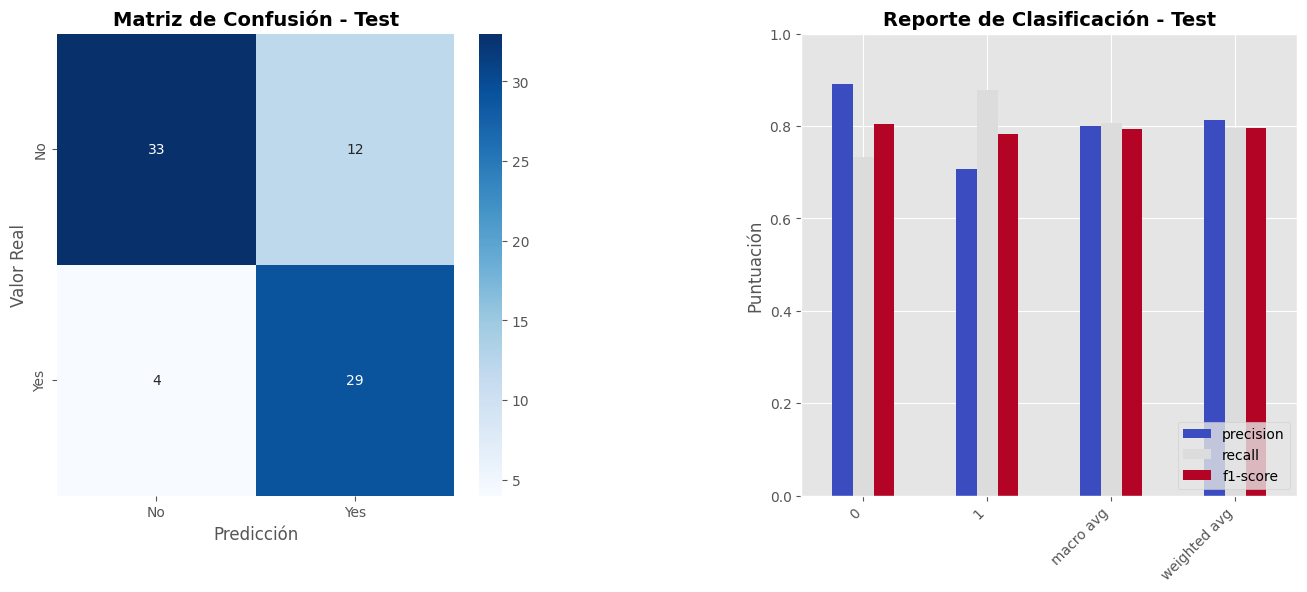

In [97]:
plot_confusion_and_report(y_test_cat, y_test_pred, 'Test')

En este caso, tenemos una diferencia de precisión algo mayor entre Train y Test, por lo que es posible que estemos cometiendo sobreajuste.

Guardamos las métricas en un pickle para su posterior productivización.

In [98]:
# Diccionario con métricas ya calculadas
metricas_guardadas = {
    "Train": {
        "confusion_matrix": confusion_matrix(y_train_cat, y_train_pred).tolist(),
        "classification_report": classification_report(y_train_cat, y_train_pred, output_dict=True)
    },
    "Test": {
        "confusion_matrix": confusion_matrix(y_test_cat, y_test_pred).tolist(),
        "classification_report": classification_report(y_test_cat, y_test_pred, output_dict=True)
    }
}

# Guardar en un archivo pickle
with open("Metricas/xg_boost.pkl", "wb") as file:
    pickle.dump(metricas_guardadas, file)


In [99]:
# Guardar el modelo en un archivo .pkl
file_path = "Modelos/xg_boost.pkl"
with open(file_path, "wb") as file:
    pickle.dump(xgboost, file)

print(f"Modelo guardado en {file_path}")

Modelo guardado en Modelos/xg_boost.pkl
